In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import sys, os
sys.path.append("..")

import torch
from omegaconf import OmegaConf
from prec_models import construct_model_class
from prec_models.sw_unet import SW_UNet, SW_UNet_light
model_list = [SW_UNet, SW_UNet_light]
model_classes = {cl.__name__: cl for cl in model_list}
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [46]:
logs_path = os.path.join(os.sep, "data", "data_data_assimilation", "log_dump", "SW")
smoke_path = os.path.join(os.sep, "GNlearning", "SW")
artifacts_path = os.path.join(smoke_path, "artifacts")

In [47]:
model_path = OmegaConf.load(os.path.join(artifacts_path, "mlflow_run_id.yaml"))['model_path']
rank = OmegaConf.load(os.path.join(artifacts_path, "mlflow_run_id.yaml"))
config = OmegaConf.load(os.path.join(os.path.dirname(model_path), 'config.yaml'))
print(f"{model_path=}")
print(f"{config=}")

model_path='/data/data_data_assimilation/shallow_water/tmp_model_storage/cbfcaf96baa144e3891da0b406f78b3b/model.pth'
config={'model': {'dimension': 12160}, 'data': {'data_folder': '/data/data_data_assimilation/shallow_water', 'nsamples': 1000}, 'architecture': {'class': 'SW_UNet', 'rank': 3, 'n_layers': 0, 'neurons_per_layer': 0, 'batch_size': 1, 'lr': 1e-10, 'n_rnd_vectors': 0}, 'optimizer': {'epochs': 30}, 'DA': {'n_cycle': 10, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 0.5, 'obs_error_sqrt': 3.0}}


In [48]:
torch_model = construct_model_class(
    model_classes[config["architecture"]["class"]],
    rank=config["architecture"]["rank"],
)
state_dimension = config["model"]["dimension"]
model = torch_model(state_dimension=state_dimension, config=config["architecture"])

UNet: 0.725184432 Gb


In [49]:
model.load_state_dict(torch.load(model_path))
model.eval()

dummy(
  (layers): UNet(
    (activation): LeakyReLU(negative_slope=0.01)
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (dropout): Dropout(p=0.1, inplace=False)
    (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
    (enc_layers1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
    )
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (e21): Conv2d(64, 128, kernel_siz

In [50]:
eta_slice = slice(None, 64**2)
u_slice = slice(64**2, 64**2 + 63*64)
v_slice = slice(64**2 + 64*63, None)

def get_control_2D(state):
    n_batch = state.shape[0]
    return (
        state[:, eta_slice].reshape(n_batch, 64, 64),
        state[:, u_slice].reshape(n_batch, 63, 64),
        state[:, v_slice].reshape(n_batch, 64, 63),
    )

In [51]:
data = np.load('/data/data_data_assimilation/shallow_water/gn_data_033.npy')
state = data[:, 0]

In [52]:
def plot_state(state):
    eta, u, v = get_control_2D(state.reshape(-1, state_dimension))
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(131)
    im1 = ax1.imshow(eta.squeeze().T)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(u.squeeze().T)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    ax3 = fig.add_subplot(133)
    im3 = ax3.imshow(v.squeeze().T)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()

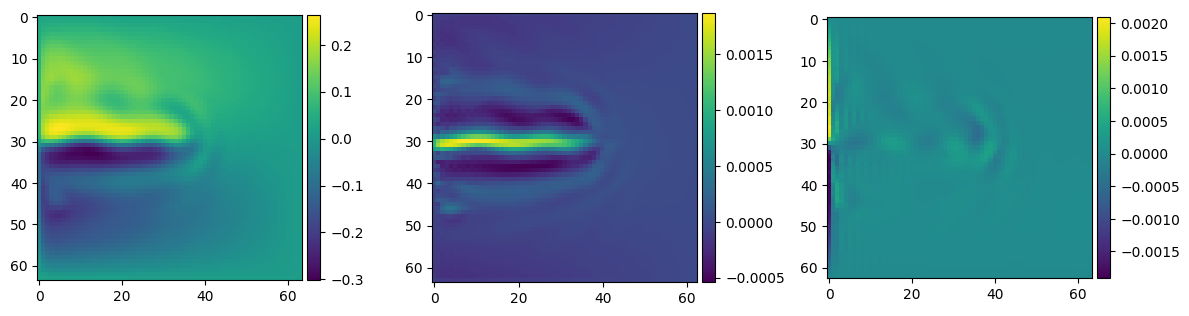

In [53]:
plot_state(data[:, 0]/(40*4))

In [54]:
def inference_model(state):
    A_approx, singular_values, _vectors = model.to("cuda").construct_approx(
        torch.tensor(state.reshape(-1, state_dimension), device="cuda")
    )
    sorted_idx = np.argsort(singular_values.cpu().detach().numpy().squeeze())[::-1]
    singular_values = singular_values.cpu().detach().numpy().squeeze()[sorted_idx]
    _vectors = _vectors.squeeze().cpu().detach().numpy()[:, sorted_idx]
    vectors = np.linalg.qr(_vectors)[0]
    return A_approx, singular_values, vectors, _vectors

In [55]:
data = np.load('/data/data_data_assimilation/shallow_water/gn_data_033.npy')
state = data[:, 0]
A_approx, singular_values, vectors, _vecs1 = inference_model(state)
data2 = np.load('/data/data_data_assimilation/shallow_water/gn_data_500.npy')
state2 = data2[:, 0]
A_approx2, singular_values2, vectors2, _vecs2 = inference_model(state2)

In [56]:
data[:, 5] - data2[:, 5]

array([-1.71308321, -1.69482679, -2.00481634, ..., -2.07950988,
        2.60098903, -3.67205416])

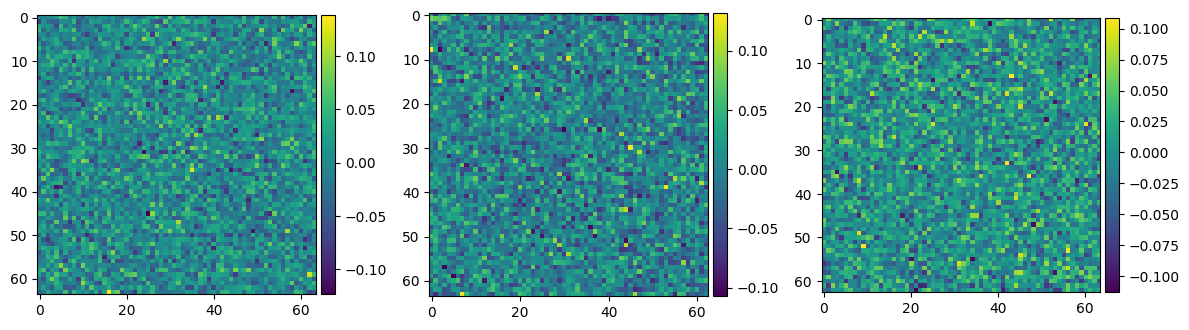

<Figure size 640x480 with 0 Axes>

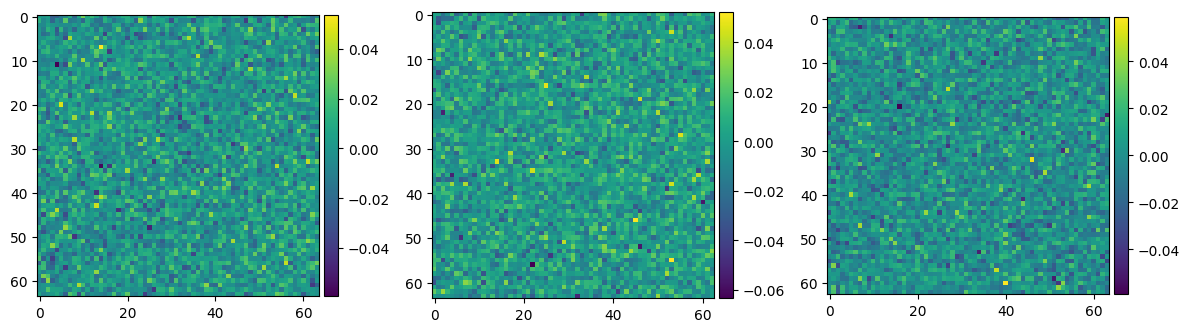

<Figure size 640x480 with 0 Axes>

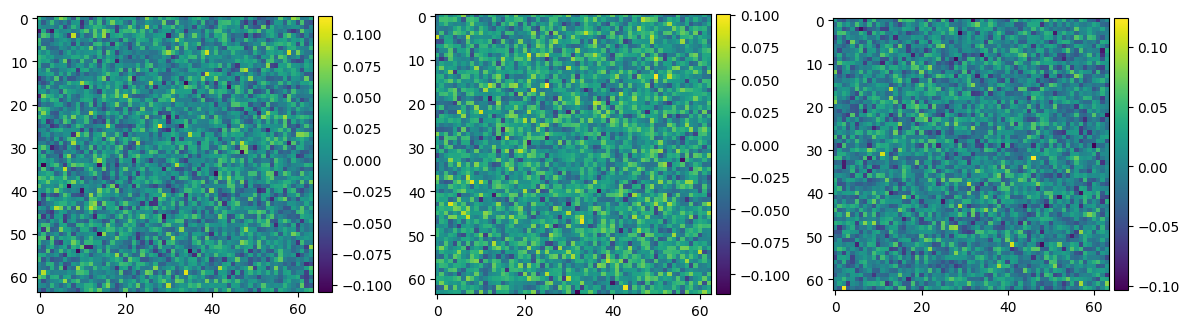

<Figure size 640x480 with 0 Axes>

In [57]:
for idx in range(3):
    plot_state(_vecs1[:, idx])
    plt.figure()

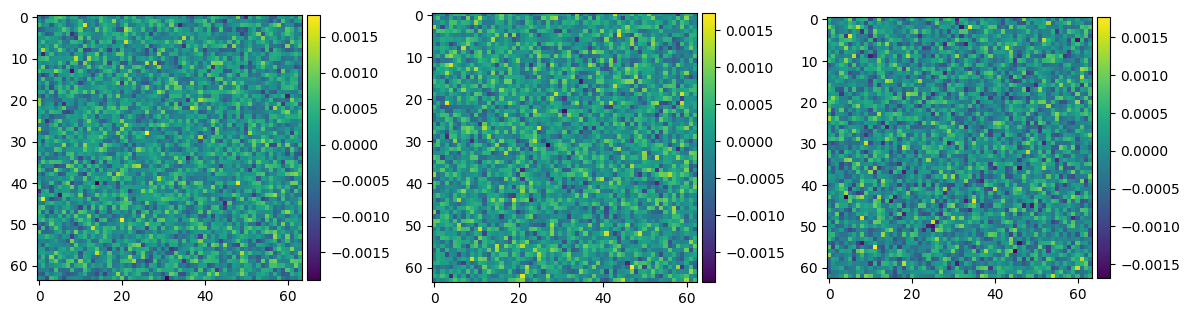

<Figure size 640x480 with 0 Axes>

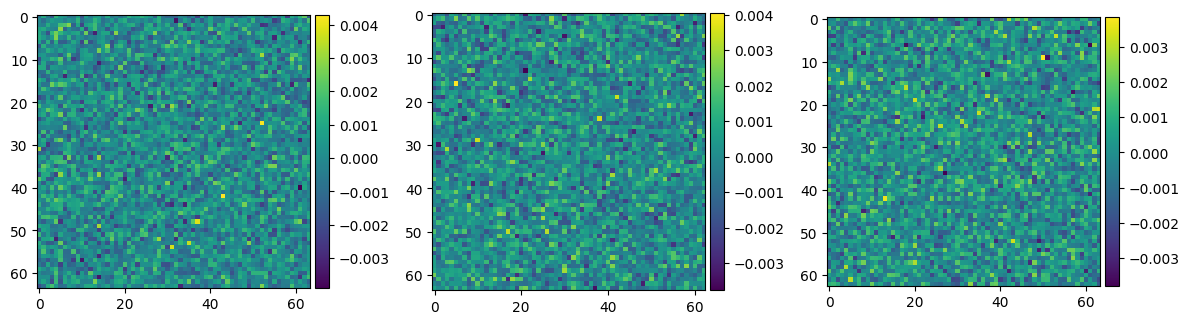

<Figure size 640x480 with 0 Axes>

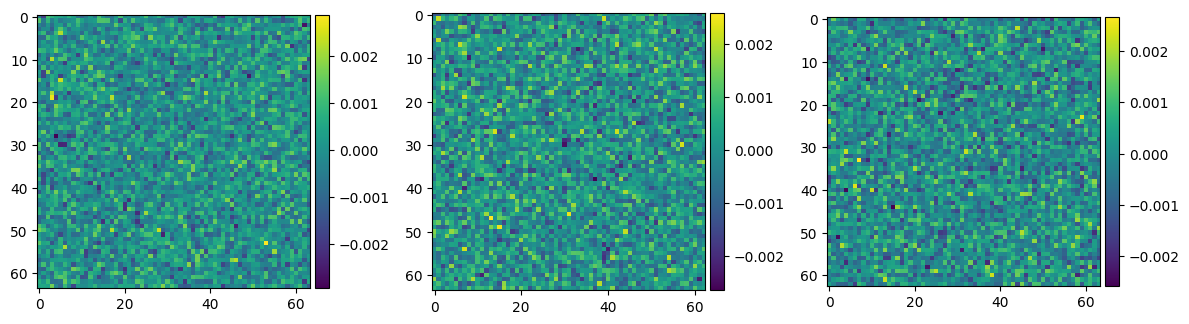

<Figure size 640x480 with 0 Axes>

In [58]:
for idx in range(3):
    plot_state(vectors[:, idx]-vectors2[:, idx])
    plt.figure()

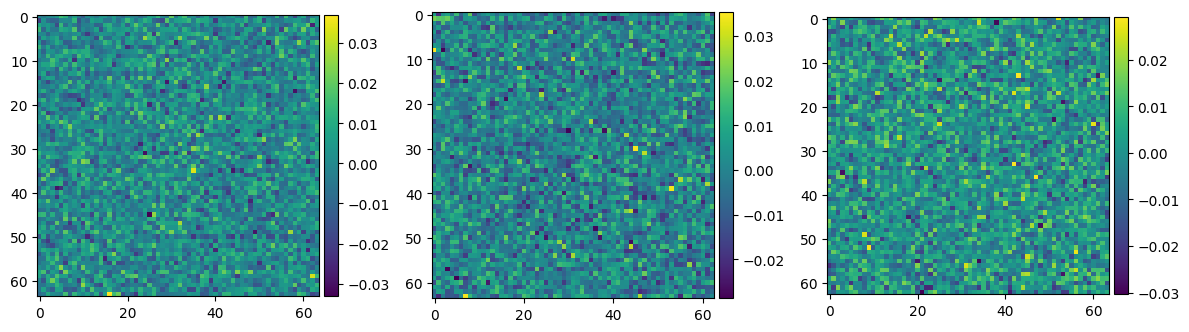

<Figure size 640x480 with 0 Axes>

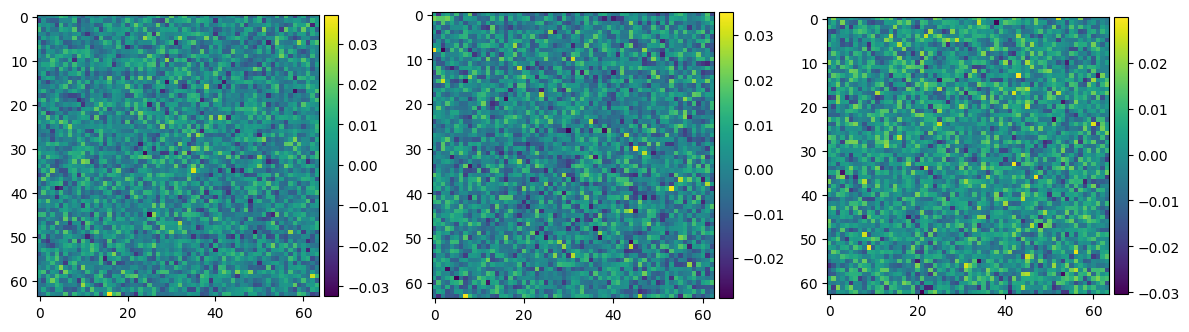

<Figure size 640x480 with 0 Axes>

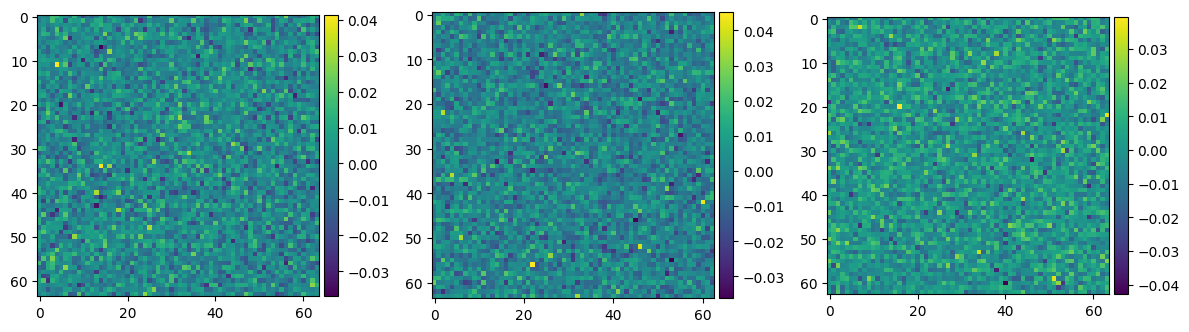

<Figure size 640x480 with 0 Axes>

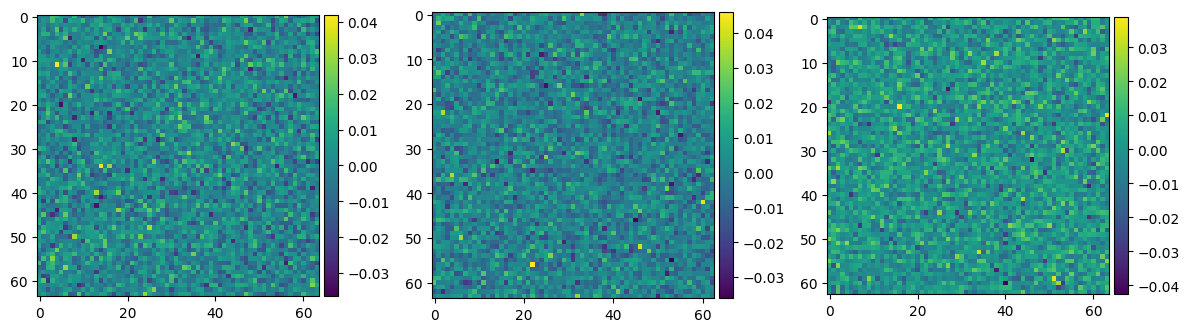

<Figure size 640x480 with 0 Axes>

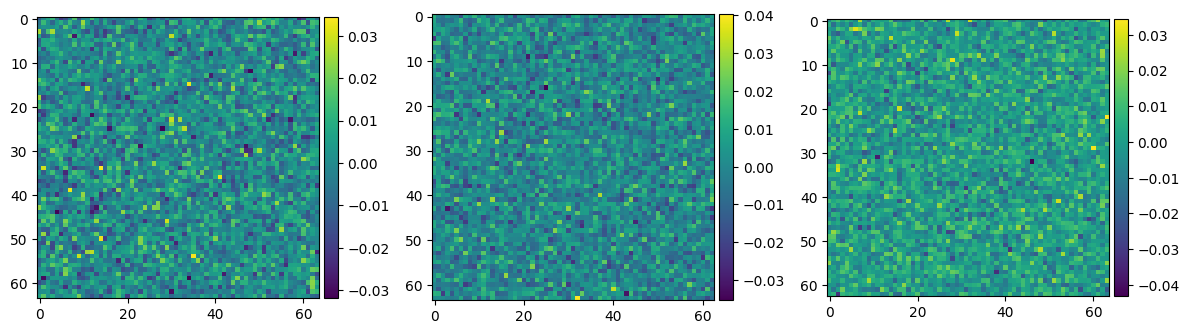

<Figure size 640x480 with 0 Axes>

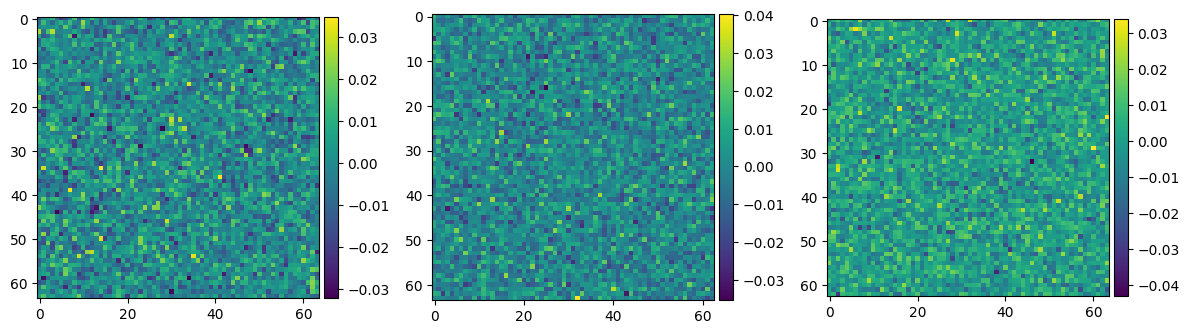

<Figure size 640x480 with 0 Axes>

In [59]:
for idx in range(3):
    plot_state(vectors[:, idx])
    plt.figure()
    plot_state(vectors2[:, idx])
    plt.figure()